#### 1. RFM segmentation
      a. Calculate RFM score by adding the individual scores  
      b. Calculate RFM score by combining the individual scores      
#### 2. Customer segmentation with K-means 

      a. k-means clustering      
      b. Interpret segments with the average RFM values      
      c. Interpret segments with the snake plot

# 1. RFM segmentation 

RFM is a method used to segment customers. RFM segmentation stands for Recency, Frequency and Monetary value segmentation.
we are going to calculate three customer behavior metrics:
- Recency - which measures how recent was each customer's last purchase
- Frequency - which measures how many purchases the customer has done 
- MonetaryValue - measures how much has the customer spent.
We will use these values to assign customers to RFM segments

In [9]:
import psycopg2
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import boto3
from io import StringIO

import warnings
warnings.filterwarnings("ignore")

In [10]:
import os

from dotenv import load_dotenv
load_dotenv()  # only for local testing


dbname = os.getenv("dbname")
host = os.getenv("host")
port = os.getenv("port")
user = os.getenv("user")
password = os.getenv("password")

In [11]:
# connect to redshift

def connect_to_redshift(dbname, host, port, user, password):
    """definition to connect to redshift"""

    connect = psycopg2.connect(
            dbname=dbname, host=host, port=port, user=user, password=password
        )

    cursor = connect.cursor()
    
    print("connection to redshift made")
    
    return connect, cursor

In [12]:
connect, cursor = connect_to_redshift(dbname, host, port, user, password)

connection to redshift made


In [13]:
query="""select *
        from bootcamp.online_transactions_cleaned otc"""

In [14]:
online_transactions_cleaned=pd.read_sql(query,connect)

In [15]:
online_transactions_cleaned.head()

,invoice,stock_code,description,price,quantity,total_order_value,invoice_date,customer_id,country
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,1.25,24,30.00,2010-12-01 08:45:00,u12583,France
1,536385,22783,SET 3 WICKER OVAL BASKETS W LIDS,19.95,1,19.95,2010-12-01 09:56:00,u1742,United Kingdom
2,536392,22128,PARTY CONES CANDY ASSORTED,1.25,12,15.00,2010-12-01 10:29:00,u13705,United Kingdom
3,536404,22469,HEART OF WICKER SMALL,1.65,12,19.80,2010-12-01 11:29:00,u16218,United Kingdom
4,536412,22274,FELTCRAFT DOLL EMILY,2.95,2,5.90,2010-12-01 11:49:00,u1792,United Kingdom


In [16]:
#just invoices with quantity>0 including 2011 are analysed
online_transactions_cl=online_transactions_cleaned[online_transactions_cleaned['quantity']>0]

In [17]:
#we take a look of the number of customers, which are segmented in this analysis
print("Number of customers:", len(online_transactions_cl.customer_id.unique()))

Number of customers: 4335


In [18]:
online_transactions_cl.invoice_date.min()

Timestamp('2010-12-01 08:26:00')

In [19]:
#let´s see the latest day
online_transactions_cl.invoice_date.max()

Timestamp('2011-12-09 12:50:00')

In [20]:
#We define present as a date that is one day after the last day
import datetime as dt
present = dt.datetime(2011,12,10)

we are now going to perform following opertaions:
   - For Recency, Calculate the number of days between present date and date of last purchase each customer.
   - For Frequency, Calculate the number of orders for each customer.
   - For Monetary, Calculate sum of total order value for each customer.

In [21]:
rfm=online_transactions_cl.groupby('customer_id').agg({'invoice_date':lambda date:(present-date.max()).days,
                                                      'invoice':'count',
                                                      'total_order_value':'sum'})

In [22]:
rfm.head()

,invoice_date,invoice,total_order_value
customer_id,,,
u12346,325,1,77183.60
u12347,2,182,4310.00
u12348,75,27,1437.24
u12349,18,72,1457.55
u1235,310,16,294.40


In [23]:
#we rename the columns
rfm.columns=['recency','frequency','monetary']

In [24]:
rfm.head()

,recency,frequency,monetary
customer_id,,,
u12346,325,1,77183.60
u12347,2,182,4310.00
u12348,75,27,1437.24
u12349,18,72,1457.55
u1235,310,16,294.40


In [25]:
rfm_1 = pd.DataFrame(rfm)
rfm_1.head()

,recency,frequency,monetary
customer_id,,,
u12346,325,1,77183.60
u12347,2,182,4310.00
u12348,75,27,1437.24
u12349,18,72,1457.55
u1235,310,16,294.40


In [26]:
# We break customers into 4 groups of equal size based on percentile values of each metric
rfm_1['r_quartile'] = pd.qcut(rfm_1['recency'], 4, ['1','2','3','4'])
rfm_1['f_quartile'] = pd.qcut(rfm_1['frequency'], 4, ['4','3','2','1'])
rfm_1['m_quartile'] = pd.qcut(rfm_1['monetary'], 4, ['4','3','2','1'])

In [27]:
rfm_1.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
customer_id,,,,,,
u12346,325,1,77183.60,4,4,1
u12347,2,182,4310.00,1,1,1
u12348,75,27,1437.24,3,3,2
u12349,18,72,1457.55,2,2,2
u1235,310,16,294.40,4,4,4


### a. Methode1: Calculate RFM score by adding the individual scores

In [28]:
# Convert RFM scores to numeric type
rfm_1['r_quartile'] = rfm_1['r_quartile'].astype(int)
rfm_1['f_quartile'] = rfm_1['f_quartile'].astype(int)
rfm_1['m_quartile'] = rfm_1['m_quartile'].astype(int)

In [29]:
# Calculate RFM score by adding the individual scores
rfm_1['RFM_Score_1'] = rfm_1['r_quartile'] + rfm_1['f_quartile'] + rfm_1['m_quartile']
rfm_1.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score_1
customer_id,,,,,,,
u12346,325,1,77183.60,4,4,1,9
u12347,2,182,4310.00,1,1,1,3
u12348,75,27,1437.24,3,3,2,8
u12349,18,72,1457.55,2,2,2,6
u1235,310,16,294.40,4,4,4,12


In [30]:
# Create a new column for RFM Customer Segments
rfm_1['Segments'] = ''

# Assign RFM segments based on the RFM score
rfm_1.loc[rfm_1['RFM_Score_1'] >= 3, 'Segments'] = 'Best Customers'
rfm_1.loc[(rfm_1['RFM_Score_1'] >= 4) & (rfm_1['RFM_Score_1'] < 10), 'Segments'] = 'Loyal Customers'
rfm_1.loc[(rfm_1['RFM_Score_1'] >= 10) & (rfm_1['RFM_Score_1'] < 11), 'Segments'] = 'At Risk Customers'
rfm_1.loc[(rfm_1['RFM_Score_1'] >= 11) & (rfm_1['RFM_Score_1'] <= 12), 'Segments'] = "Lost Customers"

rfm_1.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score_1,Segments
customer_id,,,,,,,,
u12346,325,1,77183.60,4,4,1,9,Loyal Customers
u12347,2,182,4310.00,1,1,1,3,Best Customers
u12348,75,27,1437.24,3,3,2,8,Loyal Customers
u12349,18,72,1457.55,2,2,2,6,Loyal Customers
u1235,310,16,294.40,4,4,4,12,Lost Customers


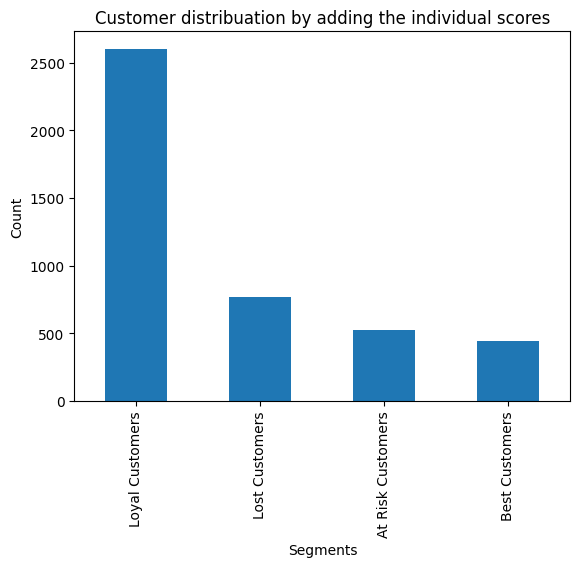

In [31]:
rfm_1.Segments.value_counts().plot(kind = 'bar')
plt.title("Customer distribuation by adding the individual scores")
plt.xlabel("Segments")
plt.ylabel("Count")
plt.show();

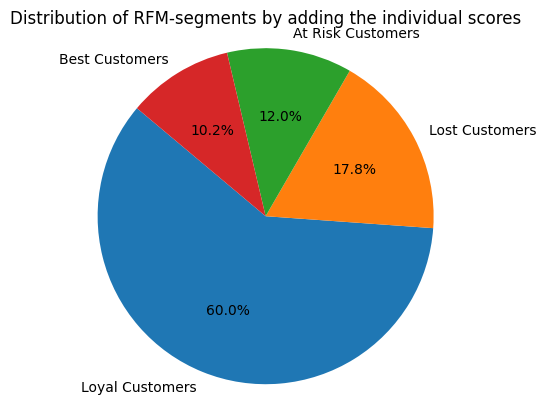

In [32]:
segment_counts = rfm_1['Segments'].value_counts()
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Distribution of RFM-segments by adding the individual scores')
plt.show()

### b. Method 2:Calculate RFM score by combining the individual scores

In [33]:
rfm_2 = pd.DataFrame(rfm_1)
rfm_2.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score_1,Segments
customer_id,,,,,,,,
u12346,325,1,77183.60,4,4,1,9,Loyal Customers
u12347,2,182,4310.00,1,1,1,3,Best Customers
u12348,75,27,1437.24,3,3,2,8,Loyal Customers
u12349,18,72,1457.55,2,2,2,6,Loyal Customers
u1235,310,16,294.40,4,4,4,12,Lost Customers


In [34]:
rfm_2['RFM_Score_2'] = rfm_1.r_quartile.astype(str)+ rfm_1.f_quartile.astype(str) + rfm_1.m_quartile.astype(str)
rfm_2.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score_1,Segments,RFM_Score_2
customer_id,,,,,,,,,
u12346,325,1,77183.60,4,4,1,9,Loyal Customers,441
u12347,2,182,4310.00,1,1,1,3,Best Customers,111
u12348,75,27,1437.24,3,3,2,8,Loyal Customers,332
u12349,18,72,1457.55,2,2,2,6,Loyal Customers,222
u1235,310,16,294.40,4,4,4,12,Lost Customers,444


In [35]:
# we group customers into segments based on recency,frequency and monetary
seg_map={
    r'[1][1][1]': 'Best customers', 
    r'[1-2-3][1-2-3][1-2-3-4]':'loyal customers',
    r'[3-4][1-2-3-4][1-2-3]':'At risk customers',
    r'[3-4][2-3-4][3-4]':'Lost customers',
    r'[1-2][2-3-4][1-2-3-4]':'new customers'
    
}
rfm_2['Segment']=rfm_2['RFM_Score_2'].replace(seg_map,regex=True)
rfm_2.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score_1,Segments,RFM_Score_2,Segment
customer_id,,,,,,,,,,
u12346,325,1,77183.60,4,4,1,9,Loyal Customers,441,At risk customers
u12347,2,182,4310.00,1,1,1,3,Best Customers,111,Best customers
u12348,75,27,1437.24,3,3,2,8,Loyal Customers,332,loyal customers
u12349,18,72,1457.55,2,2,2,6,Loyal Customers,222,loyal customers
u1235,310,16,294.40,4,4,4,12,Lost Customers,444,Lost customers


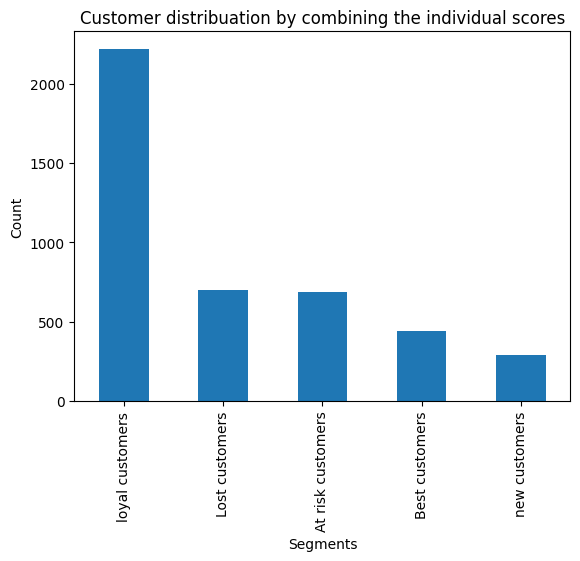

In [36]:
rfm_2.Segment.value_counts().plot(kind = 'bar')
plt.title("Customer distribuation by combining the individual scores")
plt.xlabel("Segments")
plt.ylabel("Count")
plt.show();

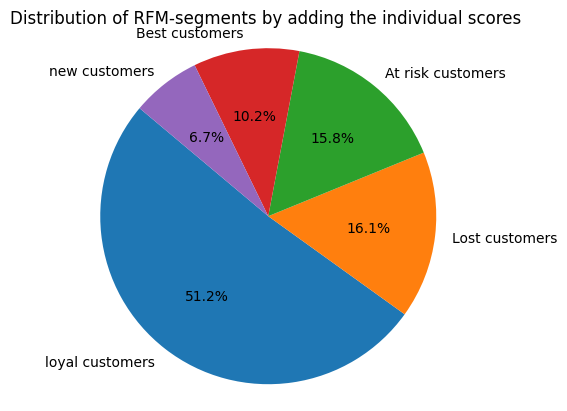

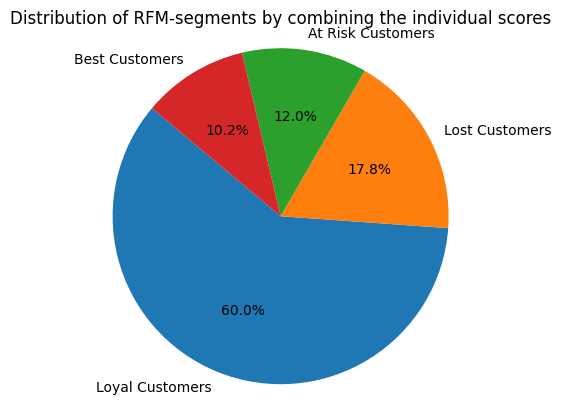

In [37]:
segment_counts = rfm_2['Segment'].value_counts()
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Distribution of RFM-segments by adding the individual scores ')
plt.show()
segment_counts = rfm_2['Segments'].value_counts()
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Distribution of RFM-segments by combining the individual scores')
plt.show()

The segmentation using the two methods conclude to the same results. However the segmentation based of adding the individual RFM-score is more precise. During the segments in the segmentation based on combining the individual RFM-score are estimated manually und that can be complex and takes a lot of time.

the segments are:

Best customers: 10.2% of customers have made recent, frequent and high-value purchases. They need exclusive offers, and personalized service experiences.

New customers: 6.7% of customers have made recent purchases but not very frequently and have not yet spent a lot. The goal here is to nurture and convert them into loyal customers.

Loyal customers: between 51.2% and 60% of customers make relatively recent and frequent purchases but have lower monetary values compared to the best customers. These customers are engaged and have a history of repeat purchases. we have to creat them offer for repeated purchases.

At risk customers: between 12% and 15.8%. These customers have not made recent purchases,their purchase frequency has decreased and their monetary value may var. They need more attention by offering them exclusive discounts to re-engage them.

Lost customers: between 16.1% and 17.8% of customers haven't made purchases recently und don't buy frequently and have low overall spending. You may need to create win-back campaigns to reactivate them.


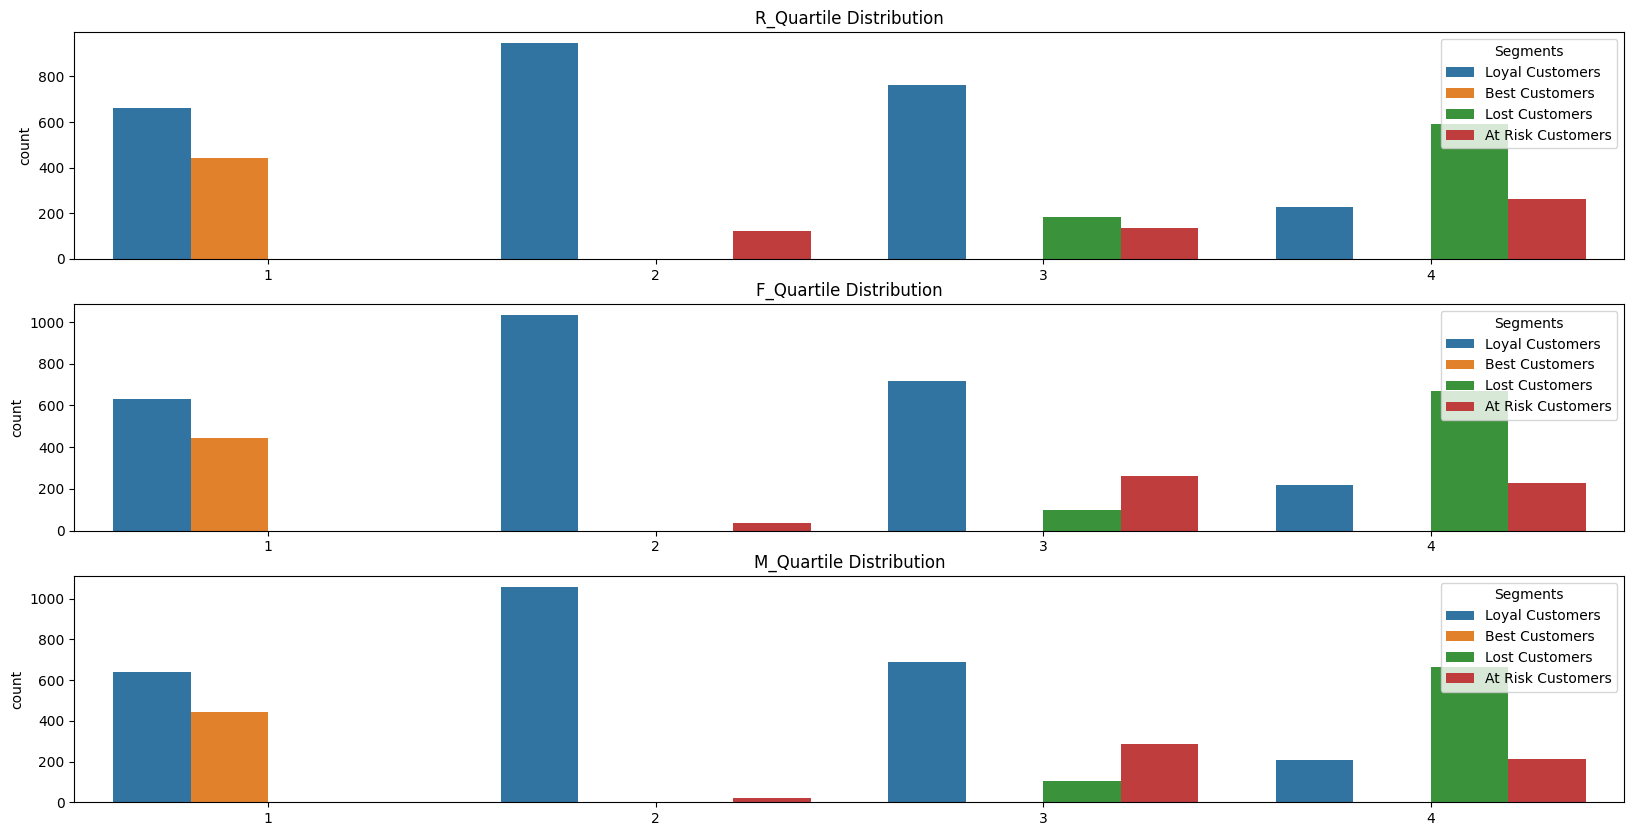

In [38]:
plt.figure(figsize=(20,10))

plt.subplot(3,1,1)
plt.title('R_Quartile Distribution')
sns.countplot(x='r_quartile', hue='Segments', data=rfm_2)
plt.xlabel('')

plt.subplot(3,1,2)
plt.title('F_Quartile Distribution')
sns.countplot(x='f_quartile',  hue='Segments', data=rfm_2)
plt.xlabel('')

plt.subplot(3,1,3)
plt.title('M_Quartile Distribution')
sns.countplot(x='m_quartile',  hue='Segments', data=rfm_2)
plt.xlabel('')
plt.show()

In [39]:
rfm_1.groupby('Segments').agg({'recency':['mean','min','max'],
                             'frequency': ['mean','min','max'],
                             'monetary': ['mean','min','max']})

recency            frequency                monetary   
                         mean min  max        mean  min   max         mean   
Segments                                                                     
At Risk Customers  151.938697  18  373   21.034483    1    84   361.469676  \
Best Customers       6.595023   0   17  371.466063  100  7667  9302.927760   
Lost Customers     217.518807  51  373   10.920882    1    39   197.420402   
Loyal Customers     57.611538   0  373   79.902308    1  1174  1654.798378   

                                       
                       min        max  
Segments                               
At Risk Customers    20.80    1351.45  
Best Customers     1634.31  279138.02  
Lost Customers        3.75     660.00  
Loyal Customers       0.00  168472.50

In [40]:
rfm_2.groupby('Segments').agg({'recency':['mean','min','max'],
                             'frequency': ['mean','min','max'],
                             'monetary': ['mean','min','max']})

recency            frequency                monetary   
                         mean min  max        mean  min   max         mean   
Segments                                                                     
At Risk Customers  151.938697  18  373   21.034483    1    84   361.469676  \
Best Customers       6.595023   0   17  371.466063  100  7667  9302.927760   
Lost Customers     217.518807  51  373   10.920882    1    39   197.420402   
Loyal Customers     57.611538   0  373   79.902308    1  1174  1654.798378   

                                       
                       min        max  
Segments                               
At Risk Customers    20.80    1351.45  
Best Customers     1634.31  279138.02  
Lost Customers        3.75     660.00  
Loyal Customers       0.00  168472.50

# 2. Customer segmentation with K-means

## a. k-means clustering

In [41]:
rfm.head()

,recency,frequency,monetary
customer_id,,,
u12346,325,1,77183.60
u12347,2,182,4310.00
u12348,75,27,1437.24
u12349,18,72,1457.55
u1235,310,16,294.40


In [42]:
rfm.dtypes

recency        int64
frequency      int64
monetary     float64
dtype: object

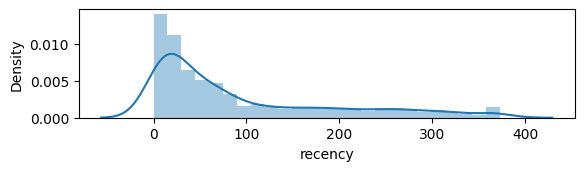

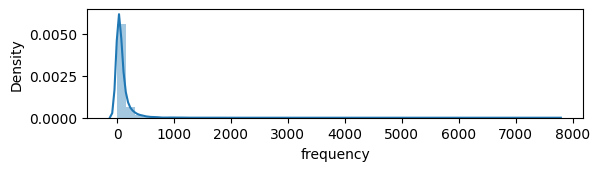

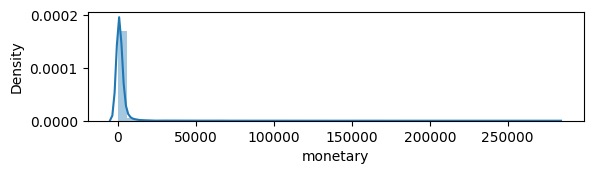

In [43]:
#visualizing the data
plt.subplot(3,1,1); sns.distplot(rfm['recency'])
plt.show()
plt.subplot(3,1,2); sns.distplot(rfm['frequency'])
plt.show()
plt.subplot(3,1,3); sns.distplot(rfm['monetary'])
plt.show()

Recency has a tail on the right, that means, it is skewed. 
frequency and monetary are also right skewed. the most observations in frequency are between 0 and 500 and in monetary betwenn 0 and 10000. wihle the other values are between 500 and 7800 in frequency and between 75000 and 275000 in monetary.
let make:

1.the skewness more symmetrical with logarithmic transformation. Some of the values are likely equal to zero. To handle this issue,we can add a small constant to avoid taking the logarithm of zero.

2.centring and scaling with Standardscaler.

In [44]:
# unskew the data
import numpy as np
# Add a small constant to 'recency' to avoid zero or negative values
small_constant = 1e-10  
rfm_log = np.log(rfm + small_constant )

In [45]:
# centring and scaling with Standardscaler
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(rfm_log )
rfm_normalized= scaler.transform(rfm_log)
rfm_normalized=pd.DataFrame(data=rfm_normalized,index=rfm.index, columns=rfm.columns)

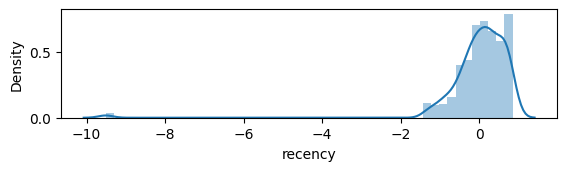

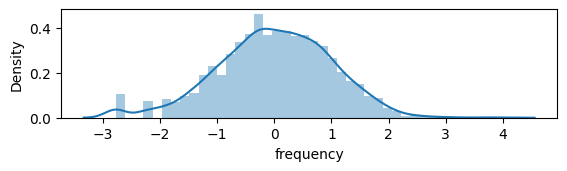

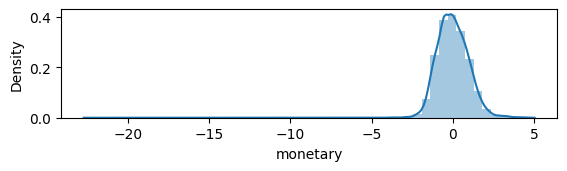

In [46]:
#vizualizing the normalised variables
plt.subplot(3,1,1); sns.distplot(rfm_normalized['recency'])
plt.show()
plt.subplot(3,1,2); sns.distplot(rfm_normalized['frequency'])
plt.show()
plt.subplot(3,1,3); sns.distplot(rfm_normalized['monetary'])
plt.show()

## chossing the number of clusters

## Elbow method

**The elbow criterion method** plots the sum of squared errors for each number of segments. The sum of squared errors is basically the sum of squared distances from each data point to their cluster center.

In [47]:
#calculate sum of squered errors for different number of clusters ranging from 1 to 15.
from sklearn.cluster import KMeans
sse={}
for k in range (1,15):
    kmeans=KMeans(n_clusters=k,random_state=1)
    kmeans.fit(rfm_normalized)
    sse[k]=kmeans.inertia_

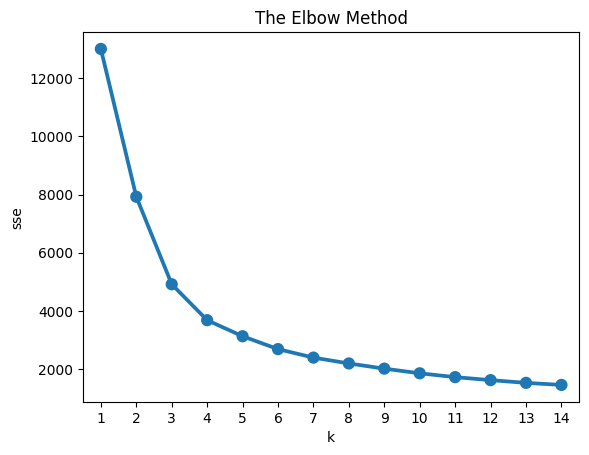

In [48]:
#plot sum of squered errors
plt.title('The Elbow Method')
plt.xlabel('k');plt.ylabel('sse')
sns.pointplot(x=list(sse.keys()),y=list(sse.values()))
plt.show()

The point 4 is the point, where the decrease in SSE slows down and becomes somewhat marginal.This point represents the optimal number of clusters from a sum-of-squared errors perspective.

## Visualizing the clusters

In [49]:
rfm_normalized.head()

,recency,frequency,monetary
customer_id,,,
u12346,0.798416,-2.775424,3.509638
u12347,-1.023070,1.162653,1.349297
u12348,0.273749,-0.281334,0.527006
u12349,-0.236885,0.460898,0.537512
u1235,0.781509,-0.677297,-0.660174


to visualize the clusters, we will do clustering in two dimensions recency and frequency

Text(0, 0.5, 'frequency')

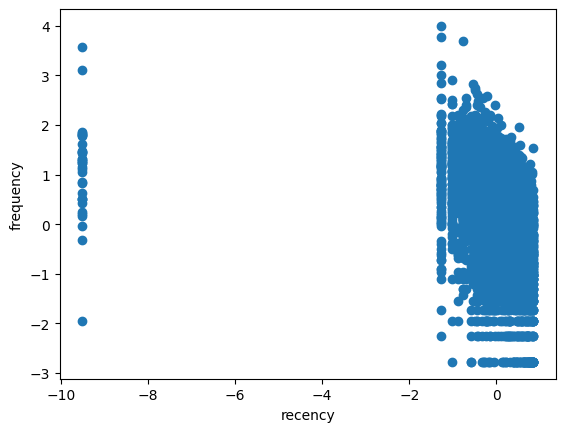

In [50]:
#visualizing the data befor the clustering
plt.scatter(rfm_normalized['recency'],rfm_normalized['frequency'])
plt.xlabel('recency')
plt.ylabel('frequency')

In [51]:
#According to the Elbow graph we deterrmine the clusters number as 4.
#we will bild now 4 clusters with k-means-clustering
kmeans=KMeans(n_clusters=4,random_state=1)
kmeans_clusters = kmeans.fit_predict(rfm_normalized )
kmeans_clusters

array([1, 3, 1, ..., 0, 3, 3])

In [52]:
kmeans.labels_

array([1, 3, 1, ..., 0, 3, 3])

In [53]:
#we creat a new column 'cluster' based on the values in the kmeans_clusters
rfm_normalized['cluster']=kmeans_clusters
rfm_normalized.head()

,recency,frequency,monetary,cluster
customer_id,,,,
u12346,0.798416,-2.775424,3.509638,1
u12347,-1.023070,1.162653,1.349297,3
u12348,0.273749,-0.281334,0.527006,1
u12349,-0.236885,0.460898,0.537512,1
u1235,0.781509,-0.677297,-0.660174,0


In [54]:
#the coordinaates of the centroid
kmeans.cluster_centers_

array([[ 0.39912699, -1.16890008, -0.99360438],
       [ 0.11967732,  0.03638147, -0.07258637],
       [-9.5099249 ,  1.09914709,  1.52090641],
       [-0.32324789,  1.11009815,  1.09646949]])

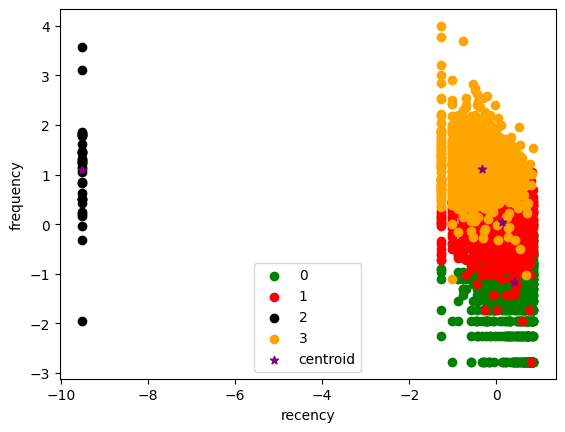

In [55]:
#Visualising the clusters
centers=kmeans.cluster_centers_
df1=rfm_normalized[rfm_normalized.cluster==0]
df2=rfm_normalized[rfm_normalized.cluster==1]
df3=rfm_normalized[rfm_normalized.cluster==2]
df4=rfm_normalized[rfm_normalized.cluster==3]
plt.scatter(df1.recency,df1.frequency,color='green',label='0')
plt.scatter(df2.recency,df2.frequency,color='red',label='1')
plt.scatter(df3.recency,df3.frequency,color='black',label='2')
plt.scatter(df4.recency,df4.frequency,color='orange',label='3')
plt.scatter(centers[:,0],centers[:,1],color='purple',marker='*',label='centroid')
plt.xlabel('recency')
plt.ylabel('frequency')
plt.legend()

We can define these clusters according to their recency and frequency:     Cluster 2 contain customers, who have made recent und frequent purchases we can name it 'diamond'.
Cluster 3 contain customers, who haven't made recent purchases, but with high frequency, we can name it 'Gold'.
Cluster 1 contain customers, who haven't made recent purchases, but with midle frequency, we can name it 'Silver'.
Cluster 0 for customers, who haven't made purchases recently und don't buy frequently, we can name it 'Bronze'.

In [56]:
rfm_norm_label=pd.DataFrame(rfm_normalized)

In [57]:
# Define the mapping
mapping = {0: 'Bronze', 1: 'Silver', 3: 'Gold', 2: 'Diamond'}

# Apply the mapping to create the 'Kmeans_Label' column
rfm_norm_label['cluster_label'] = rfm_norm_label['cluster'].map(mapping)

print(rfm_norm_label)

              recency  frequency  monetary  cluster cluster_label
customer_id                                                      
u12346       0.798416  -2.775424  3.509638        1        Silver
u12347      -1.023070   1.162653  1.349297        3          Gold
u12348       0.273749  -0.281334  0.527006        1        Silver
u12349      -0.236885   0.460898  0.537512        1        Silver
u1235        0.781509  -0.677297 -0.660174        0        Bronze
...               ...        ...       ...      ...           ...
u1828        0.741236  -1.032967 -1.026056        0        Bronze
u18281       0.586999  -1.302877 -1.628099        0        Bronze
u18282      -0.574821  -0.894997 -1.036703        0        Bronze
u18283      -0.877992   2.202303  0.789084        3          Gold
u18287       0.066285   0.439580  0.710871        3          Gold

[4335 rows x 5 columns]


<Axes: xlabel='recency', ylabel='frequency'>

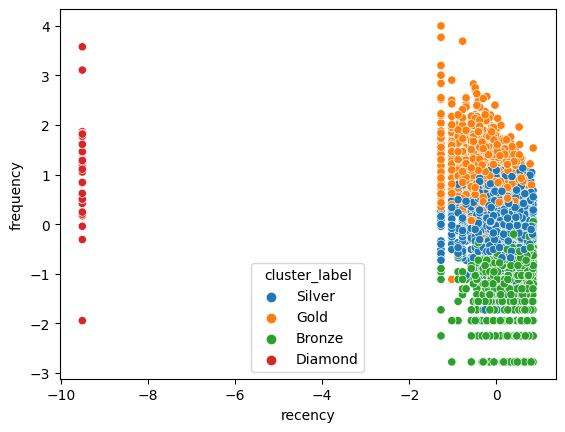

In [58]:
#scatterplot for clusters
sns.scatterplot(x='recency',y='frequency',data=rfm_norm_label,hue='cluster_label')

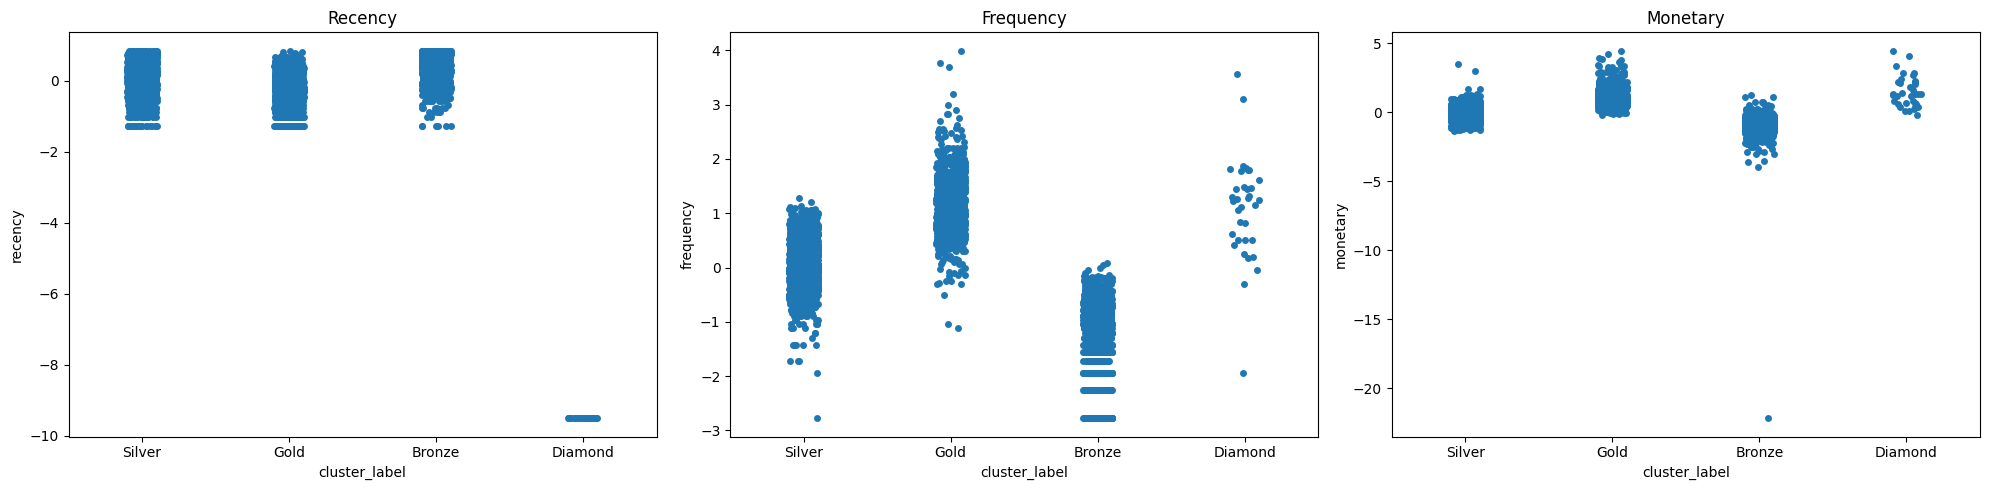

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 5))  

plt.subplot(1, 3, 1) 
sns.stripplot(x=rfm_norm_label['cluster_label'], y=rfm_norm_label['recency'])
plt.title('Recency') 

plt.subplot(1, 3, 2)
sns.stripplot(x=rfm_norm_label['cluster_label'], y=rfm_norm_label['frequency'])
plt.title('Frequency')

plt.subplot(1, 3, 3)
sns.stripplot(x=rfm_norm_label['cluster_label'], y=rfm_norm_label['monetary'])
plt.title('Monetary')

plt.tight_layout() 

plt.show()


## b. Interpret segments with the average RFM values


In [60]:
#we will now analyse the average RFM values of the 4 clusters we've created
rfm_k4= rfm.assign(cluster=kmeans.labels_).groupby(['cluster']).agg({'recency':'mean',
                                                      'frequency':'mean',
                                                      'monetary':['mean','count']}).round(2)

In [61]:
rfm_k4 

recency frequency  monetary      
           mean      mean      mean count
cluster                                  
0        161.49     10.94    249.32  1206
1         88.32     48.34    826.14  1926
2          0.00    381.60  20781.55    35
3         29.85    232.60   5253.50  1168

## c. Interpret segments with the snake plot
The snake plots is a chart that vizualise the RFM values between the Segments

In [62]:
rfm_normalized

,recency,frequency,monetary,cluster
customer_id,,,,
u12346,0.798416,-2.775424,3.509638,1
u12347,-1.023070,1.162653,1.349297,3
u12348,0.273749,-0.281334,0.527006,1
u12349,-0.236885,0.460898,0.537512,1
u1235,0.781509,-0.677297,-0.660174,0
...,...,...,...,...
u1828,0.741236,-1.032967,-1.026056,0
u18281,0.586999,-1.302877,-1.628099,0
u18282,-0.574821,-0.894997,-1.036703,0


In [63]:
print(rfm_normalized.columns)

Index(['recency', 'frequency', 'monetary', 'cluster'], dtype='object')


In [64]:
#we will transform rfm_normalized into a long format by melting recency, frequency and monatery 
#into two. One columns names Metric that will contain the original column names an other for the actuel numeric value
rfm_melt=pd.melt(rfm_normalized.reset_index(),
                id_vars=['customer_id','cluster'],
                value_vars=['recency','frequency','monetary'],
                var_name='Metric',
                value_name='value')


In [65]:
rfm_melt

,customer_id,cluster,Metric,value
0,u12346,1,recency,0.798416
1,u12347,3,recency,-1.023070
2,u12348,1,recency,0.273749
3,u12349,1,recency,-0.236885
4,u1235,0,recency,0.781509
...,...,...,...,...
13000,u1828,0,monetary,-1.026056
13001,u18281,0,monetary,-1.628099
13002,u18282,0,monetary,-1.036703
13003,u18283,3,monetary,0.789084


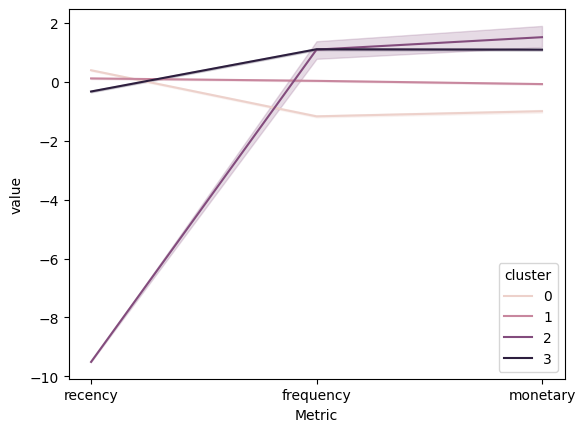

In [66]:
#vizualise snake plot
sns.lineplot(data=rfm_melt,x='Metric',y='value', hue='cluster')
plt.show()